In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure
from glob import glob
import os
from multiprocessing import Pool, cpu_count
from functools import partial
from subprocess import check_output
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from sklearn.preprocessing import LabelEncoder
not_cervix = [    
    './data/additional/Type_1/746.jpg',
    './data/additional/Type_1/2030.jpg',
    './data/additional/Type_1/4065.jpg',
    './data/additional/Type_1/4702.jpg',
    './data/additional/Type_1/4706.jpg',
    './data/additional/Type_2/1813.jpg',
    './data/additional/Type_2/3086.jpg'
]

In [16]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else: 
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i-position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()    
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea

In [17]:
def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3]+1-maxArea[0]/abs(maxArea[1]-maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

In [18]:
def cropCircle(img):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)
            
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
            
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)
    
    rect = maxRect(ff)
    rectangle = [min(rect[0],rect[2]), max(rect[0],rect[2]), min(rect[1],rect[3]), max(rect[1],rect[3])]
    img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)
    
    return [img_crop, rectangle, tile_size]

In [19]:
def im_multi(path):
    try:
        im_stats_im_ = Image.open(path)
        return [path, {'size': im_stats_im_.size}]
    except:
        print(path)
        return [path, {'size': [0,0]}]

In [20]:
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join(str(s) for s in im_stats_d[x]['size']))
    return im_stats_df

def get_im_cv2(path):
    img = cv2.imread(path)
#     added! crop image
    img = cropCircle(img)[0]
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR) #use cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return [path, resized]

def normalize_image_features(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_im_cv2, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype=np.uint8)
    fdata = fdata.transpose((0, 3, 1, 2))
    fdata = fdata.astype('float32')
    fdata = fdata / 255
    return fdata

In [7]:
train = glob('./data/train/**/*.jpg') + glob('./data/additional/**/*.jpg')
train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])#[::5] #limit for Kaggle Demo
train = im_stats(train)
train = train[train['size'] != '0 0'].reset_index(drop=True) #remove bad images
train = train[~train['path'].isin(not_cervix)] #remove not cervix image
train_data = normalize_image_features(train['path'])
np.save('train_crop_224.npy', train_data, allow_pickle=True, fix_imports=True)

le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
print(le.classes_) #in case not 1 to 3 order
np.save('train_crop_target_224.npy', train_target, allow_pickle=True, fix_imports=True)

# test = glob('./data/test/*.jpg')


/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserW

./data/additional/Type_2/2845.jpg


/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 526385152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11174. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632684544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12796. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImage

./data/additional/Type_1/5893.jpg


/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 569180160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 638386176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12883. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImage

./data/additional/Type_2/5892.jpg


/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 560791552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11699. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 505937920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512819200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.5/site-packages/PIL/TiffImagePlug

['Type_1' 'Type_2' 'Type_3']


In [21]:
test = glob('/mnt/data_temp/test_stg2/*.jpg') + glob('/mnt/data_temp/test/*.jpg')
test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path']) #[::20] #limit for Kaggle Demo
test_data = normalize_image_features(test['path'])
np.save('test_stg2_crop_224.npy', test_data, allow_pickle=True, fix_imports=True)

test_id = test.image.values
np.save('test_stg2_crop_id_224.npy', test_id, allow_pickle=True, fix_imports=True)

In [13]:
test

,image,path
0,10501.jpg,/mnt/data_temp/test_stg2/10501.jpg
1,13402.jpg,/mnt/data_temp/test_stg2/13402.jpg
2,11576.jpg,/mnt/data_temp/test_stg2/11576.jpg
3,10803.jpg,/mnt/data_temp/test_stg2/10803.jpg
4,11489.jpg,/mnt/data_temp/test_stg2/11489.jpg
5,13217.jpg,/mnt/data_temp/test_stg2/13217.jpg
6,13419.jpg,/mnt/data_temp/test_stg2/13419.jpg
7,11462.jpg,/mnt/data_temp/test_stg2/11462.jpg
8,11343.jpg,/mnt/data_temp/test_stg2/11343.jpg
9,12138.jpg,/mnt/data_temp/test_stg2/12138.jpg


In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
K.set_image_dim_ordering('th')
K.set_floatx('float32')

import pandas as pd
import numpy as np
np.random.seed(17)

train_data = np.load('train.npy')
train_target = np.load('train_target.npy')

In [13]:
def create_model(opt_='adamax'):
    model = Sequential()
    model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th', input_shape=(3, 32, 32))) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
    model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(12, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=opt_, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [14]:
datagen = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
datagen.fit(train_data)

model = create_model()
x_train, x_val_train, y_train, y_val_train = train_test_split(train_data, train_target,test_size=0.4, random_state=17)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), input_shape=(3, 32, 32..., data_format="channels_first", activation="relu")`
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", strides=(2, 2), pool_size=(2, 2))`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), data_format="channels_first", activation="relu")`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", strides=(2, 2), pool_size=(2, 2))`


In [33]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=15, shuffle=True), 
                    nb_epoch=100,  samples_per_epoch=len(x_train), verbose=1, 
                    validation_data=(x_val_train, y_val_train))

Epoch 1/100
 16/328 [>.............................] - ETA: 3s - loss: 0.7002 - acc: 0.6917

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, epochs=100, steps_per_epoch=328, validation_data=(array([[[...)`
  app.launch_new_instance()


328/328 [==============================] - 3s - loss: 0.7923 - acc: 0.6262 - val_loss: 0.8726 - val_acc: 0.5863
Epoch 2/100
328/328 [==============================] - 3s - loss: 0.7889 - acc: 0.6302 - val_loss: 0.8751 - val_acc: 0.5830
Epoch 3/100
328/328 [==============================] - 3s - loss: 0.7923 - acc: 0.6350 - val_loss: 0.8713 - val_acc: 0.5826
Epoch 4/100
328/328 [==============================] - 3s - loss: 0.7991 - acc: 0.6250 - val_loss: 0.8726 - val_acc: 0.5860
Epoch 5/100
328/328 [==============================] - 3s - loss: 0.7913 - acc: 0.6276 - val_loss: 0.8728 - val_acc: 0.5918
Epoch 6/100
328/328 [==============================] - 3s - loss: 0.7935 - acc: 0.6304 - val_loss: 0.8756 - val_acc: 0.5808
Epoch 7/100
328/328 [==============================] - 3s - loss: 0.7889 - acc: 0.6349 - val_loss: 0.8746 - val_acc: 0.5860
Epoch 8/100
328/328 [==============================] - 3s - loss: 0.7922 - acc: 0.6225 - val_loss: 0.8746 - val_acc: 0.5808
Epoch 9/100
328/328 

In [34]:
score = model.evaluate(x_val_train, y_val_train)
score

3168/3285 [===========================>..] - ETA: 0s

[0.88096206030344859, 0.58356164398077237]

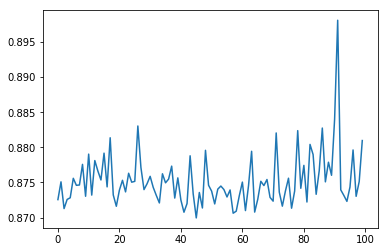

In [35]:
plt.plot(history.history['val_loss'])

In [36]:
model.save('normal_36_model_aboout600epoch')

In [ ]:
test_data = np.load('test_crop_64.npy')
test_id = np.load('test_crop_id_64.npy')
predictions = model.predict_proba(test_data, verbose=0)
df = pd.DataFrame(predictions, columns=['Type_1', 'Type_2', 'Type_3'])
df['image_name'] = test_id
df.to_csv('third_submission.csv', index=False)

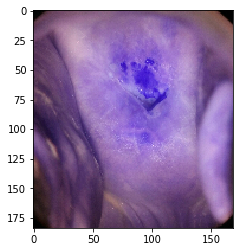

In [13]:

croped = cropCircle(img)[0]
plt.imshow(croped)

In [ ]:
sample = 